## Projection on municipalities for year 2010

In [2]:
import pandas as pd
df = pd.read_csv('../data/CosciaRios2012_DataBase.csv')
df_2010 = df[df['Year'] == 2010]
df_2010

,Code,State,Year,Beltran_Leyva,Beltran_Leyva_Family,Familia,Golfo,Juarez,Sinaloa,Sinaloa_Family,Tijuana,Zetas,Otros
20,1001,1,2010,0,0,1,0,1,0,0,0,1,0
41,1002,1,2010,0,0,1,0,0,1,0,0,0,0
62,1003,1,2010,0,0,0,0,0,0,0,0,1,0
83,1004,1,2010,0,0,0,0,0,0,0,0,0,0
104,1005,1,2010,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51491,32053,32,2010,0,0,0,0,0,0,0,0,0,0
51512,32054,32,2010,0,0,0,0,0,0,0,0,0,0
51533,32055,32,2010,0,0,0,0,0,0,0,0,1,0
51554,32056,32,2010,0,0,1,1,0,1,0,0,1,0


#### Building adjacency matrix

In [3]:
import numpy as np 

# Assuming df_2010 is already loaded
df = df_2010.copy()

# Select only cartel columns (excluding Code, State, Year)
cartel_cols = df.columns.difference(['Code', 'State', 'Year'])

# build adjacency matrix
B = df_2010.set_index('Code')[cartel_cols].astype(int)
adjacency_weighted = B @ B.T #dot product only computes sum of families whose multiplication gives 1
np.fill_diagonal(adjacency_weighted.values, 0)

adjacency_weighted

Code,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,...,32048,32049,32050,32051,32052,32053,32054,32055,32056,32057
Code,,,,,,,,,,,,,,,,,,,,,
1001,0,1,1,0,1,1,0,0,0,0,...,1,1,0,0,0,0,0,1,2,0
1002,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,2,0
1003,1,0,0,0,1,1,0,0,0,0,...,1,1,0,0,0,0,0,1,1,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1005,1,0,1,0,0,1,0,0,0,0,...,1,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32054,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32055,1,0,1,0,1,1,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0


In [4]:
#checking for symmetry in the adjacency matrix
adjacency_weighted.equals(adjacency_weighted.T)

True

#### Creating edge list from adjacency matrix for faster processing

In [5]:
import numpy as np
import pandas as pd
import networkx as nx

A = adjacency_weighted.values  #numpy
labels = adjacency_weighted.index.to_numpy()  # municipality codes

# indices of upper triangle, excluding diagonal
rows, cols = np.triu_indices(A.shape[0], k=1) #pairs of indices

# weights at those positions
weights = A[rows, cols]

# keep only existing edges
mask = weights > 0

edge_list = np.column_stack((
    labels[rows[mask]],
    labels[cols[mask]],
    weights[mask]
))

print(f'number of edges: {mask.sum()}')
edge_list

number of edges: 138469


array([[ 1001,  1002,     1],
       [ 1001,  1003,     1],
       [ 1001,  1005,     1],
       ...,
       [32049, 32056,     1],
       [32051, 32056,     1],
       [32055, 32056,     1]], dtype=int64)

#### Create graph from edge list

In [6]:
import networkx as nx

G = nx.Graph()
# add all municipalities 
G.add_nodes_from(adjacency_weighted.index)

# add edges from edge list
G.add_weighted_edges_from(edge_list)
print(f'entire graph for 2010 → edges: {G.number_of_edges()}, nodes: {G.number_of_nodes()}, number of connected commponents: {nx.number_connected_components(G)}')

G_conn = nx.Graph()
G_conn.add_weighted_edges_from(edge_list)
print(f'filtered graph for 2010 → edges: {G_conn.number_of_edges()}, nodes: {G_conn.number_of_nodes()}, number of connected commponents: {nx.number_connected_components(G_conn)}')

entire graph for 2010 → edges: 138469, nodes: 2456, number of connected commponents: 1748
filtered graph for 2010 → edges: 138469, nodes: 709, number of connected commponents: 1


#### Visualizing the network

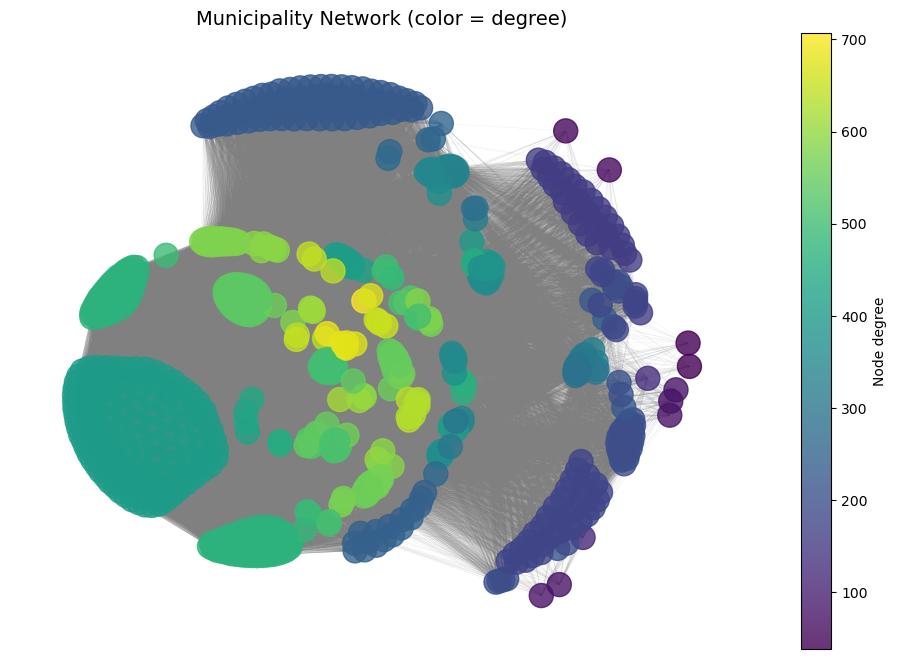

In [113]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Compute node degree for size scaling
degree_dict = dict(G_conn.degree()) 

# Define layout (spring)
pos = nx.kamada_kawai_layout(G_conn, weight='weight') #use edge weight to pull stronger ties closer 

# Draw nodes
plt.figure(figsize=(12, 8))
nodes = nx.draw_networkx_nodes(
    G_conn, pos,
    node_color=list(degree_dict.values()),
    cmap='viridis',
    alpha=0.8
)

# Draw edges with transparency
nx.draw_networkx_edges(
    G_conn, pos,
    width=0.2,
    alpha=0.2,
    edge_color='gray'
)

# Colorbar for degree
cbar = plt.colorbar(nodes)
cbar.set_label('Node degree')

plt.title("Municipality Network (color = degree)", fontsize=14)
plt.axis('off')
plt.show()

It cannot be seen clearly in this graph, but the idea here is to say that for each family present in a group of municipalities, they will be connected in the same clique, likely forming communities. The exact same coloring shows that nodes have the exact same degree and the gray coloring of the edges show the dense connection caused  by a single family being present in a group of municipalities

#### Finding most important nodes and edges in the network

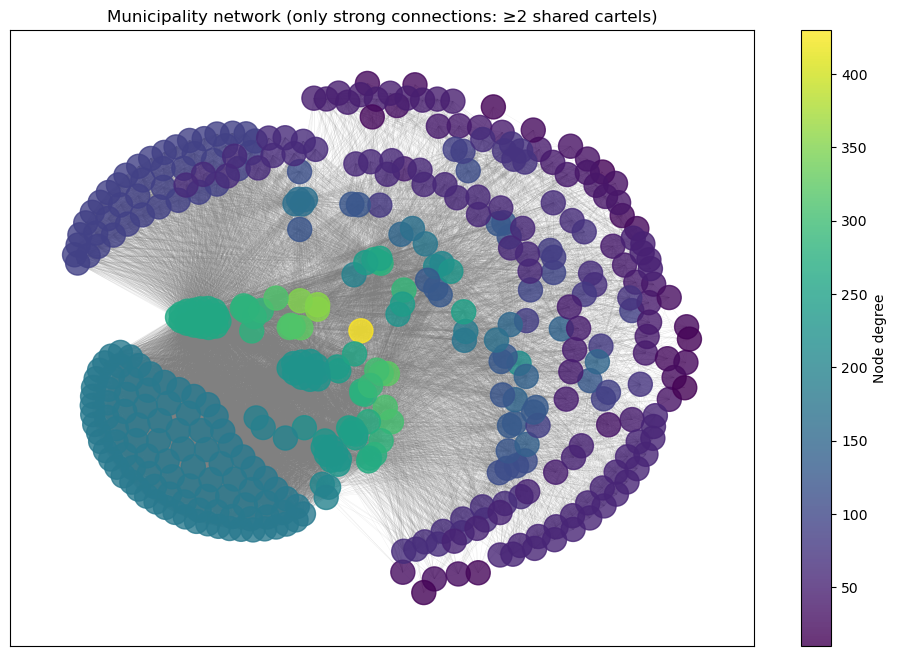

In [128]:
# Keep only edges with weight ≥ 2 (i.e., share at least two cartels)
edges_strong = edge_list[edge_list[:,2] >= 2]
G_strong = nx.Graph()
G_strong.add_weighted_edges_from(edges_strong)

degree_dict = dict(G_strong.degree()) 

pos = nx.kamada_kawai_layout(G_strong, weight='weight') #use edge weight to pull stronger ties closer

plt.figure(figsize=(12, 8))

nodes = nx.draw_networkx_nodes(
    G_strong, pos,
    node_color=list(degree_dict.values()),
    cmap='viridis',
    alpha=0.8
)


# Draw edges with transparency
nx.draw_networkx_edges(
    G_strong, pos,
    width=0.2,
    alpha=0.2,
    edge_color='gray'
)

# Colorbar for degree
cbar = plt.colorbar(nodes)
cbar.set_label('Node degree')

plt.title("Municipality network (only strong connections: ≥2 shared cartels)")
plt.show()

#### Finding most important nodes and edges in the network

In this plot we observe nodes that have at least 2 families present in them, so we have way fewer nodes, fewer edges and less cliques. We can see the max degree is around 450, in contrast with the high degree above 700 we observed on the entire connected component. This suggests there are families that dominate a huge group of municipalities.

#### Community detection

C:\Users\Maribel ITU\AppData\Local\Temp\ipykernel_18004\2195198311.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=cm.get_cmap('tab10', max(colors)+1), node_size=20)


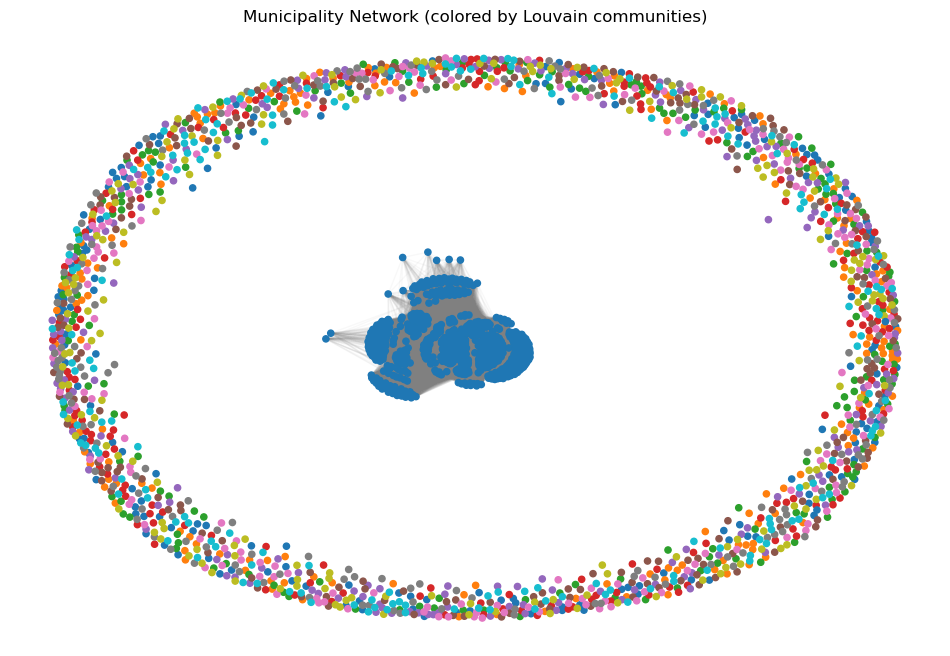

In [9]:
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import matplotlib.cm as cm

partition = community_louvain.best_partition(G)
colors = [partition[n] for n in G.nodes()]

pos = nx.spring_layout(G, k=0.4, iterations=60, seed=42) #use edge weight to pull stronger ties closer

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=cm.get_cmap('tab10', max(colors)+1), node_size=20)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.05)
plt.title("Municipality Network (colored by Louvain communities)")
plt.axis('off')
plt.show()

It can be clearly seen here that all isolated nodes are assigned to their own community whereas the connected component in the middle is treated as one community. We are mostly interested in communities inside the connected component, so we work with G_conn

C:\Users\Maribel ITU\AppData\Local\Temp\ipykernel_18004\1039774226.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw_networkx_nodes(G_conn, pos, node_color=colors, cmap=cm.get_cmap('tab10', max(colors)+1))


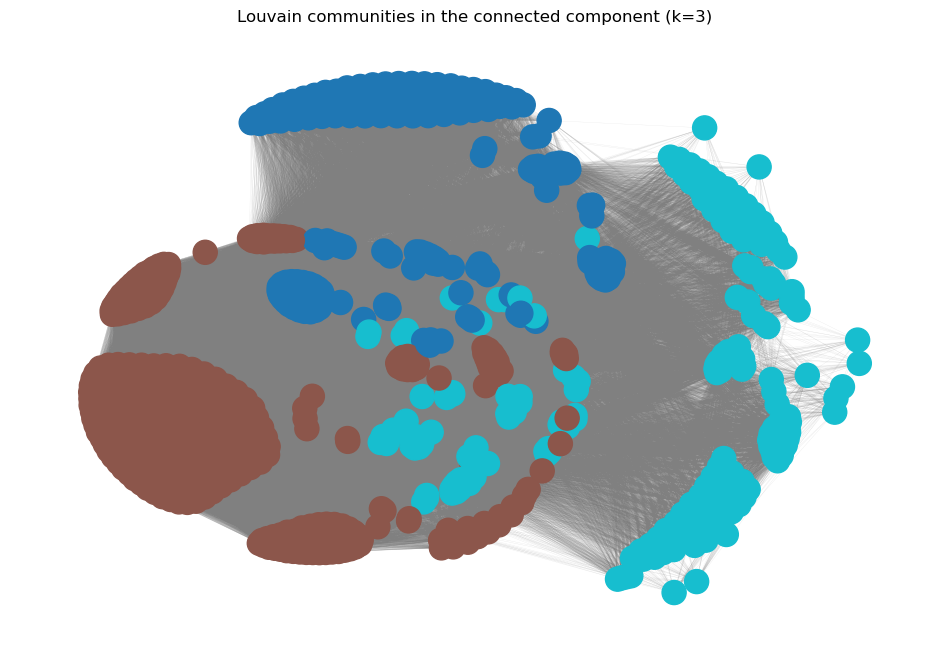

In [12]:
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import matplotlib.cm as cm

partition = community_louvain.best_partition(G_conn)
colors = [partition[n] for n in G_conn.nodes()]

pos = nx.kamada_kawai_layout(G_conn, weight='weight') #use edge weight to pull stronger ties closer 

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_conn, pos, node_color=colors, cmap=cm.get_cmap('tab10', max(colors)+1))
nx.draw_networkx_edges(G_conn, pos, edge_color='gray', width=0.2, alpha=0.2)
plt.title(f"Louvain communities in the connected component (k={max(partition.values()) + 1})")
plt.axis('off')
plt.show()

This pattern in communities resembles a lot the pattern observed when coloring by node degree. This makes sense since nodes with the same degree are almost always connected together forming cliques.

#### Coloring nodes by states

C:\Users\Maribel ITU\AppData\Local\Temp\ipykernel_24152\649990500.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(set(state_values)))  # also try 'tab20b' or 'nipy_spectral'


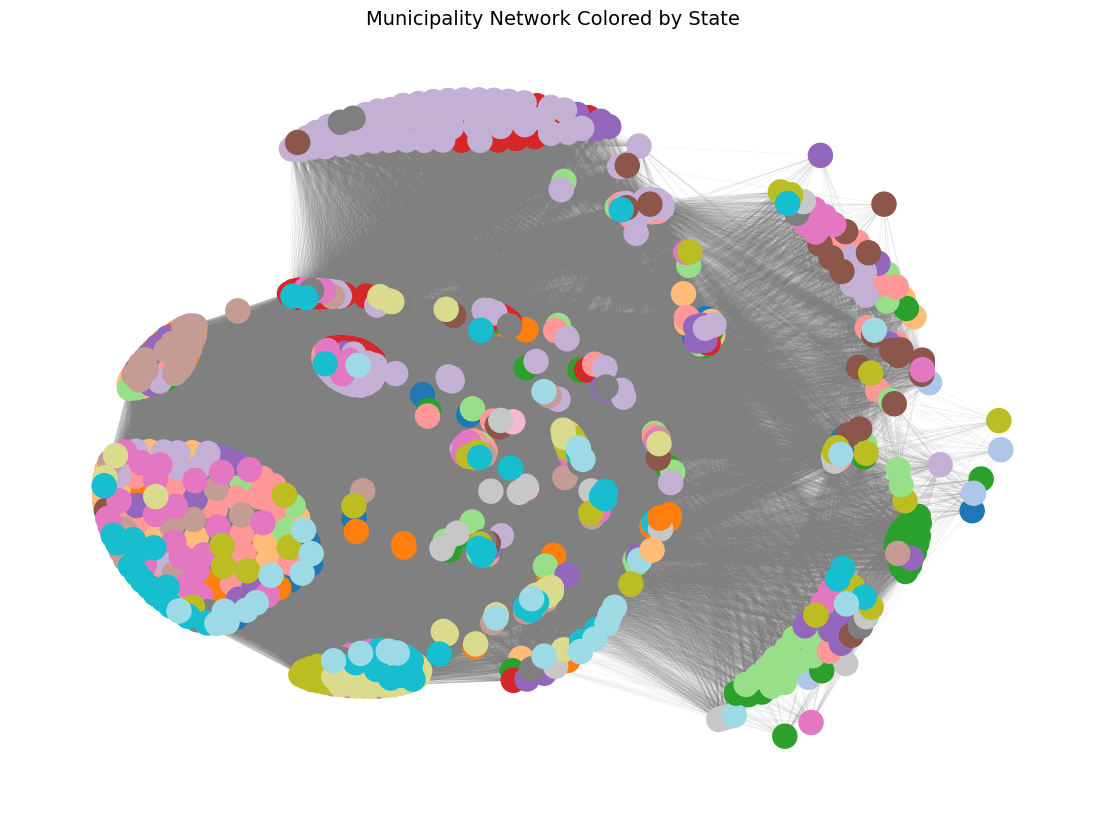

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# creating a dictionary of codes as keys and states as values
state_map = df.set_index('Code')['State'].to_dict()
state_values = [state_map[node] for node in G_conn.nodes()]

#creating a color map for each state
cmap = cm.get_cmap('tab20', len(set(state_values)))  # also try 'tab20b' or 'nipy_spectral'
pos = nx.kamada_kawai_layout(G_conn, weight='weight')

plt.figure(figsize=(14, 10))

nx.draw_networkx_nodes(
    G_conn,
    pos,
    node_color=state_values,
    cmap=cmap,
)

nx.draw_networkx_edges(
    G_conn,
    pos,
    width=0.2,
    alpha=0.2,
    edge_color='gray'
)

plt.title("Municipality Network Colored by State", fontsize=14)
plt.axis('off')
plt.show()

We observe that communities/connections do not show a tendency to occur within the same state so there is more than a geographical pattern here

#### Node centrality evaluation for later robustness testing of the network

In [ ]:
deg_cent = nx.degree_centrality(G_strong)
top_degree = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 municipalities by degree centrality:")
for code, score in top_degree:
    print(f"{code}: {score:.3f}")

Top municipalities by degree centrality:
8037: 0.999
17007: 0.968
17018: 0.968
10007: 0.966
12001: 0.962
25011: 0.956
22014: 0.953
15033: 0.945
15058: 0.928
19009: 0.918
